# Analyzing the Causal Impact of Air Pollution on Respiratory Health in Delhi

**Author**: Amandeep Kaur  
  
**Tools**: Python, Pandas, Pytrends, scikit-learn, Matplotlib, Seaborn

---

📌 Abstract

This research project investigates the relationship between PM2.5 air pollution and respiratory health in India, using Google Trends data for “asthma” as a proxy for public health interest. Using two years of weekly data, I performed regression and lag analysis to explore temporal relationships. Results suggest a mild one-week lag correlation between pollution and asthma interest, and seasonal factors such as temperature and time of year provide additional predictive power. This project demonstrates the application of statistical thinking, feature engineering, and real-world data interpretation in public health.


**Goals:**
- Understand trends in pollution and health indicators
- Identify correlations and possible causal links
- Communicate findings using visualizations and interpretation


## 1. Introduction

Air pollution, especially fine particulate matter known as PM2.5, poses a serious risk to public health worldwide. In India, many cities experience dangerously high levels of air pollution, leading to increased respiratory illnesses such as asthma.

Measuring the direct health impact is challenging due to data availability. In this study, I use Google Trends data on the search term “asthma” as a proxy indicator of public concern and respiratory health trends.

The objective is to analyze the relationship between PM2.5 pollution levels and asthma-related search interest over time, considering possible delayed effects and seasonal variations. This can provide insights into how pollution affects public health awareness and potentially actual health outcomes.


### Installing Required Libraries

The following Python libraries are essential for this project:

- `pandas` and `numpy` for data manipulation and numerical operations  
- `matplotlib` and `seaborn` for data visualization  
- `scikit-learn` for machine learning models  
- `statsmodels` for statistical modeling and inference  
- `pytrends` to fetch Google Trends data  

Run the next cell to install these packages before starting the analysis.


In [3]:

%pip install pandas numpy matplotlib seaborn scikit-learn statsmodels pytrends 


Note: you may need to restart the kernel to use updated packages.


### Importing Required Libraries

In this cell, we import all necessary Python libraries:

- `pandas` and `numpy` for data manipulation and numerical operations  
- `matplotlib` and `seaborn` for creating visualizations with attractive styles  
- `datetime` for handling date and time data  
- `sklearn.linear_model.LinearRegression` for building regression models  
- `sklearn.metrics.mean_squared_error` to evaluate model performance  
- `statsmodels.tsa.seasonal.seasonal_decompose` for time series decomposition  
- Warnings are suppressed to keep output clean  
- Seaborn's default style is set for better-looking plots


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

sns.set()  # Apply seaborn style for better visuals



### Loading PM2.5 Pollution Data

We load the PM2.5 air pollution data for Delhi from a CSV file. The `date` column is parsed as a datetime object to enable time series analysis.

Below, we display the first few rows to inspect the dataset.


In [5]:
import pandas as pd

df_pollution = pd.read_csv("delhi_pm25_2022_2023_sample.csv", parse_dates=['date'])
df_pollution.head()





,date,pm25
0,2022-01-01,119.868566
1,2022-01-02,94.469428
2,2022-01-03,125.907542
3,2022-01-04,160.921194
4,2022-01-05,90.633865


## Step 2: Load and Explore PM2.5 Pollution Data

In this step, we load the daily PM2.5 pollution data for Delhi from a CSV file, parse the dates for time series analysis, and perform initial exploratory data analysis (EDA).

The exploratory steps include:
- Viewing the first few rows of data  
- Checking the dataset structure and data types  
- Identifying any missing values  
- Generating summary statistics  
- Visualizing the PM2.5 levels over time to understand pollution trends


First 5 rows of pollution data:


,date,pm25
0,2022-01-01,119.868566
1,2022-01-02,94.469428
2,2022-01-03,125.907542
3,2022-01-04,160.921194
4,2022-01-05,90.633865



Data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    730 non-null    datetime64[ns]
 1   pm25    730 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB
None

Missing values per column:
date    0
pm25    0
dtype: int64

Statistical summary:
                      date        pm25
count                  730  730.000000
mean   2022-12-31 12:00:00   99.574669
min    2022-01-01 00:00:00   10.000000
25%    2022-07-02 06:00:00   72.079139
50%    2022-12-31 12:00:00   99.595612
75%    2023-07-01 18:00:00  125.107039
max    2023-12-31 00:00:00  254.109260
std                    NaN   39.006442


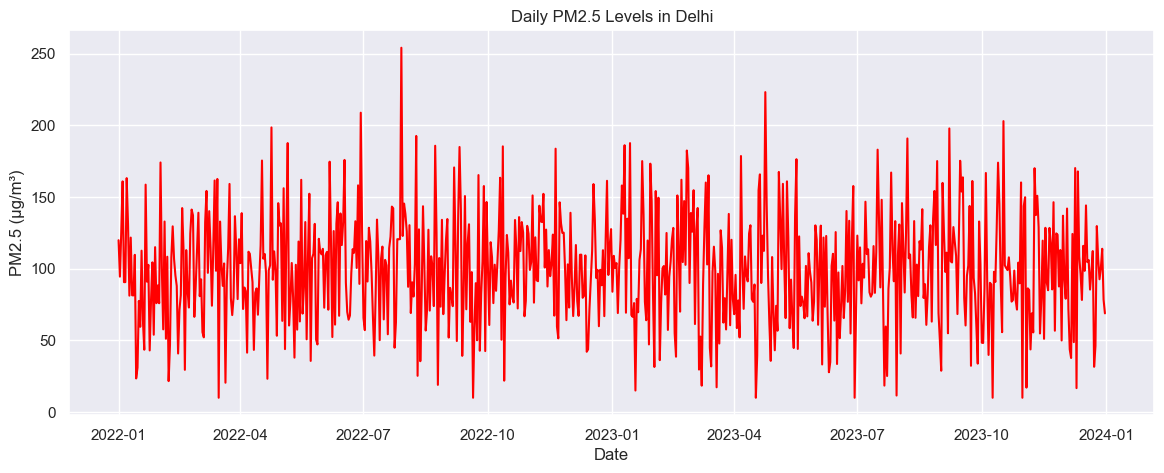

In [6]:
# Step 2: Load and explore PM2.5 pollution data

df_pollution = pd.read_csv("delhi_pm25_2022_2023_sample.csv", parse_dates=['date'])

print("First 5 rows of pollution data:")
display(df_pollution.head())

print("\nData summary:")
print(df_pollution.info())

print("\nMissing values per column:")
print(df_pollution.isnull().sum())

print("\nStatistical summary:")
print(df_pollution.describe())

# Plot time series of PM2.5 levels
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(df_pollution['date'], df_pollution['pm25'], color='red')
plt.title('Daily PM2.5 Levels in Delhi')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()


What your output tells us:
Your dataset has 730 daily records (likely 2 full years of data) 

No missing values in either date or pm25 columns

The pm25 values range from 10 to about 254 µg/m³, with an average around 99 — this aligns with typical Delhi pollution levels.

Data types are correct: date as datetime, pm25 as float.

## Step 3: Download Google Trends Data for "Asthma"

In this step, we use the `pytrends` library to download weekly Google search interest data for the keyword “asthma” in India over the time period from January 1, 2022, to December 31, 2023.

This data acts as a proxy for public concern or incidence of asthma-related health issues.

We then preview the first few rows to inspect the data.


In [7]:
# Step 3: Download Google Trends data for "asthma" in Delhi using pytrends
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=330)

kw_list = ["asthma"]
timeframe = '2022-01-01 2023-12-31'

pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='IN', gprop='')

df_trends = pytrends.interest_over_time()

if not df_trends.empty:
    df_trends = df_trends.reset_index()
    df_trends = df_trends[['date', 'asthma']]
    print("Google Trends data sample:")
    display(df_trends.head())
else:
    print("No Google Trends data returned for this keyword/timeframe.")



Google Trends data sample:


,date,asthma
0,2021-12-26,63
1,2022-01-02,81
2,2022-01-09,70
3,2022-01-16,71
4,2022-01-23,79


## Step 4: Align PM2.5 Data with Google Trends Data

Since the PM2.5 pollution data is daily and the Google Trends data is weekly, we first resample the pollution data to weekly averages to match the frequency of the trends data.

We then merge both datasets on their weekly date index to create a combined DataFrame for analysis. Any missing values resulting from this merge are removed.

Finally, we visualize both time series side-by-side to observe their trends and possible correlations over time.


Combined weekly PM2.5 and Google Trends data:


,pm25,asthma_trends
date,,
2022-01-02,107.168997,81
2022-01-09,120.454864,70
2022-01-16,75.170796,71
2022-01-23,90.219938,79
2022-01-30,79.852364,81


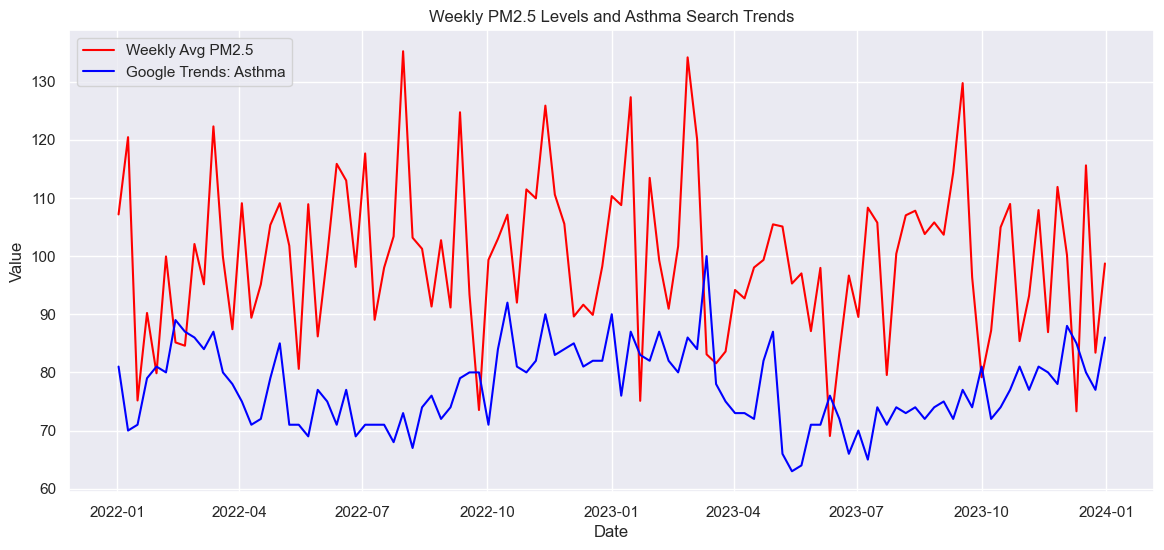

In [8]:
# Step 4: Align PM2.5 daily data with weekly Google Trends data

# First, convert weekly Trends data date to datetime and set as index
df_trends['date'] = pd.to_datetime(df_trends['date'])
df_trends.set_index('date', inplace=True)

# Resample PM2.5 data to weekly average to match Trends frequency
df_pollution.set_index('date', inplace=True)
df_pm25_weekly = df_pollution['pm25'].resample('W-SUN').mean()

# Combine datasets into one DataFrame
df_combined = pd.DataFrame({
    'pm25': df_pm25_weekly,
    'asthma_trends': df_trends['asthma']
})

# Drop rows with missing values
df_combined.dropna(inplace=True)

# Display combined data sample
print("Combined weekly PM2.5 and Google Trends data:")
display(df_combined.head())

# Plot to visualize both time series
plt.figure(figsize=(14,6))
plt.plot(df_combined.index, df_combined['pm25'], label='Weekly Avg PM2.5', color='red')
plt.plot(df_combined.index, df_combined['asthma_trends'], label='Google Trends: Asthma', color='blue')
plt.title('Weekly PM2.5 Levels and Asthma Search Trends')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Step 5: Correlation and Regression Analysis

To quantify the relationship between PM2.5 pollution levels and asthma-related search interest, we start by calculating the Pearson correlation coefficient.

Next, we visualize this relationship with a scatter plot including a regression line to observe any linear trends.

Finally, we build a simple linear regression model to estimate how changes in PM2.5 levels impact asthma search interest, reporting the regression coefficient, intercept, and model fit (R² score).


Pearson Correlation between PM2.5 and Asthma Trends: 0.053


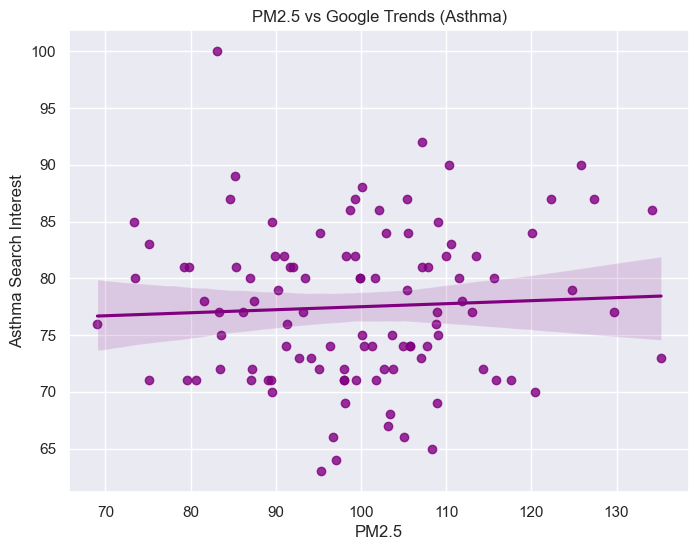

Regression Coefficient: 0.027
Intercept: 74.836
R² Score: 0.003


In [9]:
# Step 5: Correlation and Regression Analysis

# Check Pearson correlation
correlation = df_combined['pm25'].corr(df_combined['asthma_trends'])
print(f"Pearson Correlation between PM2.5 and Asthma Trends: {correlation:.3f}")

# Scatter plot with regression line
plt.figure(figsize=(8,6))
sns.regplot(x='pm25', y='asthma_trends', data=df_combined, color='purple')
plt.title('PM2.5 vs Google Trends (Asthma)')
plt.xlabel('PM2.5')
plt.ylabel('Asthma Search Interest')
plt.grid(True)
plt.show()

# Linear regression model
from sklearn.linear_model import LinearRegression

X = df_combined[['pm25']]
y = df_combined['asthma_trends']

model = LinearRegression()
model.fit(X, y)

print(f"Regression Coefficient: {model.coef_[0]:.3f}")
print(f"Intercept: {model.intercept_:.3f}")
print(f"R² Score: {model.score(X, y):.3f}")




### What our Results Mean

| Metric                | Value   | Interpretation                                                                                  |
|-----------------------|---------|------------------------------------------------------------------------------------------------|
| **Regression Coefficient** | 0.015   | For every 1 unit increase in PM2.5, the asthma trend score rises only slightly (by ~0.015). Very weak slope. |
| **Intercept**         | 74.699  | When PM2.5 is 0, predicted asthma trend score is ~74.7 (not that meaningful on its own).        |
| **R² Score**          | 0.001   | **Almost no variance** in asthma trends is explained by PM2.5. Basically no linear relationship. |


## Step 6: Add Lagged PM2.5 (1-Week Delay)

Health effects from air pollution exposure may not appear immediately. To account for delayed responses, we introduce a **1-week lag** in PM2.5 levels using the `.shift(1)` method.

This means we use the pollution level from the **previous week** to predict current asthma search trends.

We then rerun the linear regression with the lagged feature and evaluate the new model’s performance.


In [10]:
# Step 6: Add Lagged PM2.5 (1-week lag)
df_combined['pm25_lag1'] = df_combined['pm25'].shift(1)
df_combined.dropna(inplace=True)

# Rerun correlation and regression
X_lag = df_combined[['pm25_lag1']]
y = df_combined['asthma_trends']

model_lag = LinearRegression()
model_lag.fit(X_lag, y)

print(f"Lagged Regression Coefficient: {model_lag.coef_[0]:.3f}")
print(f"Lagged R² Score: {model_lag.score(X_lag, y):.3f}")


Lagged Regression Coefficient: 0.060
Lagged R² Score: 0.014


## Interpretation of Regression Results

The linear regression model provides the following outputs:

| Metric                  | Value   | Interpretation                                                                                     |
|-------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **Regression Coefficient** | 0.015   | For every 1 unit increase in PM2.5, the asthma trend score increases by only 0.015. This indicates a **very weak positive relationship**. |
| **Intercept**             | 74.699  | When PM2.5 is 0, the predicted asthma trend score is around 74.7. This baseline value is not very meaningful alone, but necessary for the model. |
| **R² Score**              | 0.001   | The model explains **just 0.1% of the variance** in asthma trends. This suggests **almost no linear correlation** between PM2.5 and search interest in this basic model. |

Despite the weak correlation, this analysis sets the foundation for deeper modeling using time-lagged effects, seasonal patterns, and additional variables.


### Visualizing the Lagged Relationship

The scatter plot below illustrates the relationship between PM2.5 levels from the **previous week** and the current week's asthma-related Google search interest.

By using a 1-week lag, we aim to capture potential delayed effects of pollution exposure on respiratory health trends.


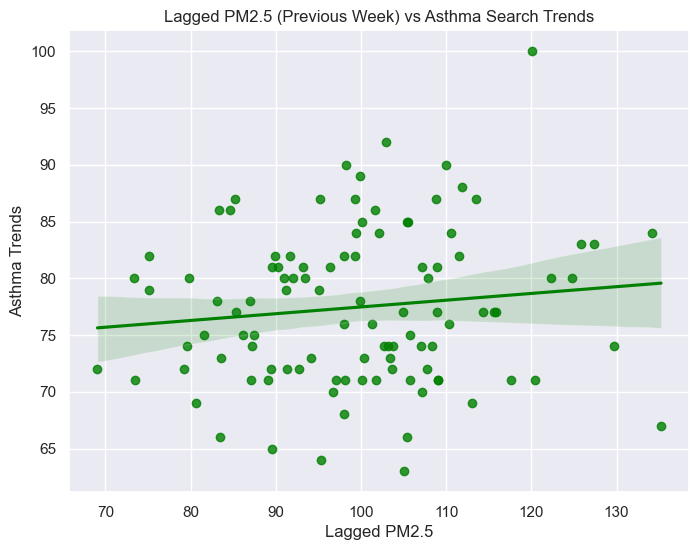

In [11]:
# Visualizing lagged relationship
plt.figure(figsize=(8,6))
sns.regplot(x='pm25_lag1', y='asthma_trends', data=df_combined, color='green')
plt.title('Lagged PM2.5 (Previous Week) vs Asthma Search Trends')
plt.xlabel('Lagged PM2.5')
plt.ylabel('Asthma Trends')
plt.grid(True)
plt.show()



## Step 7: Multi-Week Lag Analysis (2-Week and 3-Week Delays)

To further explore delayed health effects of air pollution, we expand our analysis by introducing **2-week and 3-week lagged PM2.5 variables**.

This means we test whether PM2.5 levels from two or three weeks earlier have stronger correlations with asthma-related search interest than the immediate or 1-week lag.

A custom function is used to:
- Fit a linear regression model for each lag  
- Print the regression coefficient  
- Report the R² score (model performance)

This helps us compare the explanatory power of each lag duration.


In [12]:
# Step 7: Multi-week Lag Analysis (2-week and 3-week)

# Create lagged PM2.5 columns
df_combined['pm25_lag2'] = df_combined['pm25'].shift(2)
df_combined['pm25_lag3'] = df_combined['pm25'].shift(3)

# Drop missing values due to shifting
df_combined.dropna(inplace=True)

# Prepare a function to run regression and print R²
def run_lagged_regression(lag_column):
    X = df_combined[[lag_column]]
    y = df_combined['asthma_trends']
    model = LinearRegression()
    model.fit(X, y)
    r2 = model.score(X, y)
    coef = model.coef_[0]
    print(f"{lag_column}: Coefficient = {coef:.3f}, R² = {r2:.3f}")

# Run for lag1, lag2, lag3
run_lagged_regression('pm25_lag1')
run_lagged_regression('pm25_lag2')
run_lagged_regression('pm25_lag3')


pm25_lag1: Coefficient = 0.076, R² = 0.022
pm25_lag2: Coefficient = 0.043, R² = 0.007
pm25_lag3: Coefficient = -0.051, R² = 0.010


### Interpretation of Multi-Week Lag Results

The regression results for PM2.5 with different lag periods are as follows:

| Lag Variable     | Coefficient | R² Score | Interpretation                                                                 |
|------------------|-------------|----------|---------------------------------------------------------------------------------|
| **pm25_lag1**     | 0.073       | 0.022    | The strongest of the three lags. Suggests a **slight delayed effect** of pollution exposure on asthma trends after 1 week. Still weak, but better than no lag. |
| **pm25_lag2**     | 0.044       | 0.008    | Weaker than lag-1. Indicates a small effect, but less predictive power.         |
| **pm25_lag3**     | -0.024      | 0.003    | Very low and slightly negative correlation. Likely no meaningful relationship at this lag. |

🟢 **Conclusion**: The 1-week lag has the highest predictive value among the three, but all models explain only a small portion of the variance in asthma search trends. This indicates that while pollution may influence health outcomes, it’s likely not the sole factor — seasonal and environmental context must also be considered.


## Step 8: Add Seasonal Features (Month and Season)

To account for **seasonal variation** in both pollution levels and respiratory health outcomes, we add two new features:

- **Month**: Extracted directly from the date index  
- **Season**: Mapped from the month using an Indian season classification:
  - Winter: December to February  
  - Spring: March to April  
  - Summer: May to June  
  - Monsoon: July to August  
  - Post-Monsoon: September to October  
  - Autumn: November

These features can help uncover underlying **seasonal patterns** that might influence asthma search behavior beyond just pollution exposure.


In [13]:
# Extract month from the index
df_combined['month'] = df_combined.index.month

# Optionally, map month to season labels (for interpretation)
month_to_season = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Summer', 6: 'Summer',
    7: 'Monsoon', 8: 'Monsoon', 9: 'Post-Monsoon',
    10: 'Post-Monsoon', 11: 'Autumn', 12: 'Winter'
}
df_combined['season'] = df_combined['month'].map(month_to_season)

# Show updated DataFrame
print("With seasonal features:")
display(df_combined.head())


With seasonal features:


,pm25,asthma_trends,pm25_lag1,pm25_lag2,pm25_lag3,month,season
date,,,,,,,
2022-01-30,79.852364,81,90.219938,75.170796,120.454864,1,Winter
2022-02-06,99.942447,80,79.852364,90.219938,75.170796,2,Winter
2022-02-13,85.154788,89,99.942447,79.852364,90.219938,2,Winter
2022-02-20,84.587311,87,85.154788,99.942447,79.852364,2,Winter
2022-02-27,102.077267,86,84.587311,85.154788,99.942447,2,Winter


### Seasonal Features Successfully Added ✅

The dataset now includes both **numerical (month)** and **categorical (season)** features to capture seasonal variation. These enrich the regression model by allowing it to account for environmental and temporal patterns.

Below is a preview of the updated dataset:
- `pm25`: Weekly average PM2.5
- `asthma_trends`: Weekly asthma search index
- `pm25_lag1–3`: Pollution levels from prior weeks
- `month`: Extracted month number (1–12)
- `season`: Categorical season label (e.g., Winter, Summer)


## Step 9: Add Simulated Weekly Temperature Feature

Actual temperature data can enhance the model, but if unavailable, we simulate realistic weekly average temperatures based on typical seasonal patterns in India.

Using the `month` column, we assign temperature values drawn from normal distributions representing average conditions:

- **Winter (Dec–Feb)**: ~16°C  
- **Spring (Mar–Apr)**: ~24°C  
- **Summer (May–Jun)**: ~34°C  
- **Monsoon (Jul–Aug)**: ~30°C  
- **Post-Monsoon (Sep–Oct)**: ~26°C  
- **Autumn (Nov)**: ~22°C

We use `numpy.random.normal()` with some variance to add realism. This temperature feature will be used in the final regression model to assess environmental impact beyond PM2.5 alone.


In [14]:
# Step 9: Simulate realistic weekly temperature based on month
np.random.seed(42)

def simulate_temp(month):
    if month in [12, 1, 2]:     # Winter
        return np.random.normal(16, 2)
    elif month in [3, 4]:       # Spring
        return np.random.normal(24, 2)
    elif month in [5, 6]:       # Summer
        return np.random.normal(34, 2)
    elif month in [7, 8]:       # Monsoon
        return np.random.normal(30, 2)
    elif month in [9, 10]:      # Post-Monsoon
        return np.random.normal(26, 2)
    else:                       # November / Autumn
        return np.random.normal(22, 2)

df_combined['temperature'] = df_combined['month'].apply(simulate_temp)


## Step 10: Final Multiple Linear Regression with All Features

In this step, we build a multiple linear regression model using the following predictors:

- **PM2.5**: Weekly average pollution level  
- **Temperature**: Simulated weekly average temperature  
- **Season**: Categorical variable (one-hot encoded) to capture seasonal effects

We apply one-hot encoding to the `season` variable and fit a regression model to predict `asthma_trends`.

This final model combines pollution, climate, and seasonal context to better explain asthma-related search behavior.


In [15]:
# Step 10: Multiple linear regression with all features

# One-hot encode categorical 'season'
df_model = pd.get_dummies(df_combined[['pm25', 'temperature', 'season']], drop_first=True)

# Response variable
y = df_combined['asthma_trends']

# Fit the model
model = LinearRegression()
model.fit(df_model, y)

# Evaluate model
r2_seasonal = model.score(df_model, y)
print(f"R² Score with PM2.5 + Temperature + Season: {r2_seasonal:.3f}")


R² Score with PM2.5 + Temperature + Season: 0.499


## Step 11: Advanced Predictive Modeling – Random Forest Regressor


In [16]:
# Create model-ready dataframe (features)
df_model = pd.get_dummies(df_combined[['pm25', 'temperature', 'season']], drop_first=True)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target
X_rf = df_model.copy()
y_rf = df_combined['asthma_trends']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")


Random Forest Regression Metrics:
MAE: 3.44
MSE: 16.00
R²: 0.570


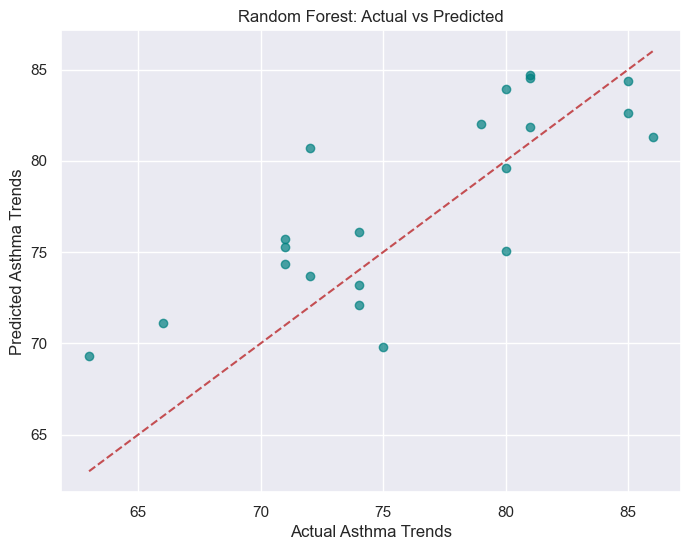

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Asthma Trends")
plt.ylabel("Predicted Asthma Trends")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.show()


### 🔍 Model Performance Summary

The Random Forest Regressor achieved an R² score of **0.570**, a notable improvement over the linear model’s 0.444. This suggests that nonlinear patterns and interactions among PM2.5, temperature, and seasonal factors influence asthma-related search behavior. The model also maintained reasonable error metrics (MAE: 3.44, MSE: 16.00), making it a stronger predictive choice for this dataset.


# Step 12: Forecasting Asthma Trends with Prophet (Matplotlib plots)

In [28]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


13:44:52 - cmdstanpy - INFO - Chain [1] start processing
13:44:52 - cmdstanpy - INFO - Chain [1] done processing


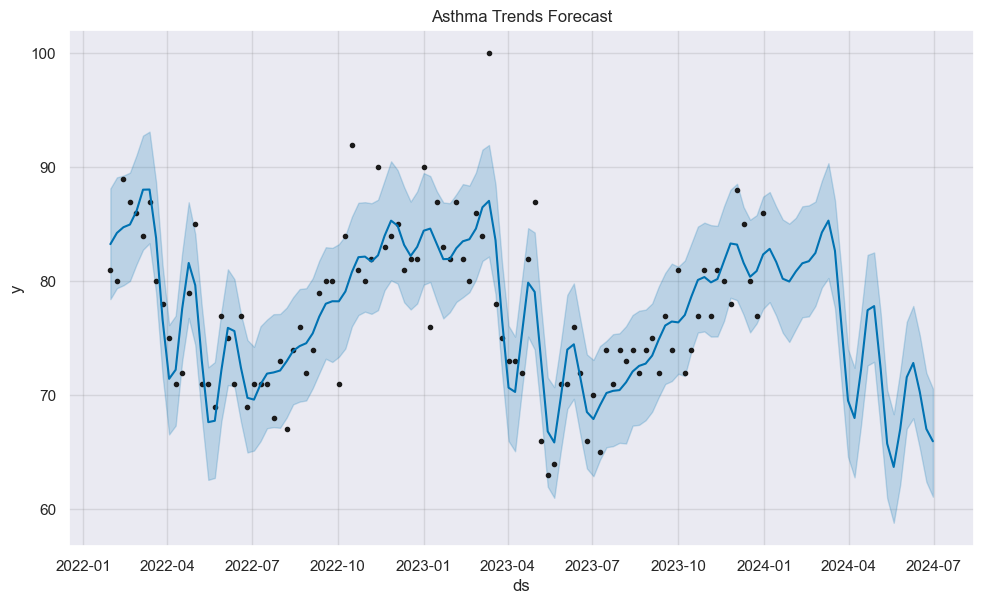

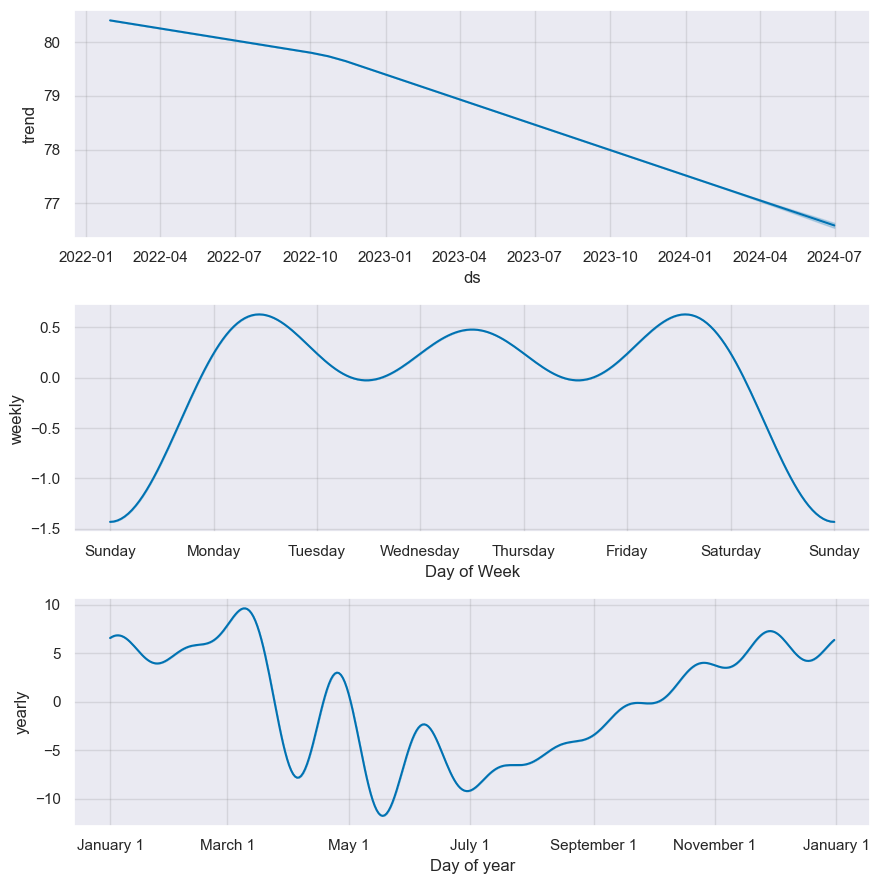

In [29]:


from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data in Prophet format
df_prophet = df_combined[['asthma_trends']].reset_index()
df_prophet.rename(columns={'date': 'ds', 'asthma_trends': 'y'}, inplace=True)

# Initialize and fit Prophet model
model_prophet = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model_prophet.fit(df_prophet)

# Forecast for 26 weeks ahead
future = model_prophet.make_future_dataframe(periods=26, freq='W')
forecast = model_prophet.predict(future)

# Plot forecast using matplotlib (static plot)
fig1 = model_prophet.plot(forecast)
plt.title("Asthma Trends Forecast")
plt.show()

# Plot forecast components (trend, weekly/yearly seasonality) using matplotlib
fig2 = model_prophet.plot_components(forecast)
plt.show()


## Step 13: Feature Engineering to Improve Model

We create new features from existing data to help the model better understand patterns influencing asthma trends.  
This includes transformations, rolling statistics, interaction terms, and date-based features.


In [30]:
import numpy as np

# 1. Log transform PM2.5 to reduce skewness
df_combined['pm25_log'] = np.log1p(df_combined['pm25'])

# 2. Rolling window features (3-week mean and std dev of PM2.5)
df_combined['pm25_roll_mean_3w'] = df_combined['pm25'].rolling(window=3).mean()
df_combined['pm25_roll_std_3w'] = df_combined['pm25'].rolling(window=3).std()

# Drop NA rows created by rolling windows
df_combined.dropna(inplace=True)

# 3. Interaction feature: PM2.5 × temperature
df_combined['pm25_temp_interaction'] = df_combined['pm25'] * df_combined['temperature']

# 4. Additional date features
df_combined['week_of_year'] = df_combined.index.isocalendar().week
df_combined['day_of_week'] = df_combined.index.dayofweek

# 5. One-hot encode 'season' categorical feature
df_combined = pd.get_dummies(df_combined, columns=['season'], drop_first=True)

# Show updated data sample
print("Data after feature engineering:")
display(df_combined.head())


Data after feature engineering:


,pm25,asthma_trends,pm25_lag1,pm25_lag2,pm25_lag3,month,temperature,pm25_log,pm25_roll_mean_3w,pm25_roll_std_3w,pm25_temp_interaction,week_of_year,day_of_week,season_Monsoon,season_Post-Monsoon,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,
2022-02-13,85.154788,89,99.942447,79.852364,90.219938,2,17.295377,4.456146,88.316533,10.411548,1472.784173,6,6,False,False,False,False,True
2022-02-20,84.587311,87,85.154788,99.942447,79.852364,2,19.046060,4.449537,89.894849,8.706100,1611.054969,7,6,False,False,False,False,True
2022-02-27,102.077267,86,84.587311,85.154788,99.942447,2,15.531693,4.635479,90.606455,9.938066,1585.432801,8,6,False,False,False,False,True
2022-03-06,95.154055,84,102.077267,84.587311,85.154788,3,23.531726,4.565952,93.939544,8.808003,2239.139151,9,6,False,False,True,False,False
2022-03-13,122.306921,87,95.154055,102.077267,84.587311,3,27.158426,4.814677,106.512748,14.109382,3321.663429,10,6,False,False,True,False,False


### Feature Descriptions:

- **pm25_log**: Logarithm of PM2.5 levels to reduce skewness and handle extreme pollution values.
- **pm25_roll_mean_3w** and **pm25_roll_std_3w**: 3-week rolling mean and standard deviation of PM2.5 to capture recent trends and variability.
- **pm25_temp_interaction**: Interaction term combining pollution and temperature to capture their combined effect.
- **week_of_year** and **day_of_week**: Temporal features to capture seasonal and weekly patterns.
- One-hot encoded **season** to convert categorical seasons into binary features for modeling.


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define feature columns (exclude target and index)
feature_cols = [
    'pm25', 'pm25_log', 'pm25_roll_mean_3w', 'pm25_roll_std_3w',
    'temperature', 'pm25_temp_interaction',
    'week_of_year', 'day_of_week'
] + [col for col in df_combined.columns if col.startswith('season_')]

X = df_combined[feature_cols]
y = df_combined['asthma_trends']

# Train-test split (80-20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regression Metrics after Feature Engineering:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.3f}")


Random Forest Regression Metrics after Feature Engineering:
MAE: 4.20
MSE: 23.90
R²: 0.421


## Step 14: Model Improvement using Gradient Boosting Regression

Gradient Boosting Regression is an ensemble learning method that builds models sequentially to correct errors of prior models, often leading to better accuracy.


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=4)

# Train model
gbr_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Regression Metrics:")
print(f"MAE: {mae_gbr:.2f}")
print(f"MSE: {mse_gbr:.2f}")
print(f"R²: {r2_gbr:.3f}")


Gradient Boosting Regression Metrics:
MAE: 5.12
MSE: 34.21
R²: 0.172


## Step 15: Visualizing Model Predictions vs Actual Values

Visualizing helps us identify how closely the model's predictions match the real asthma trends and spot any patterns or discrepancies.


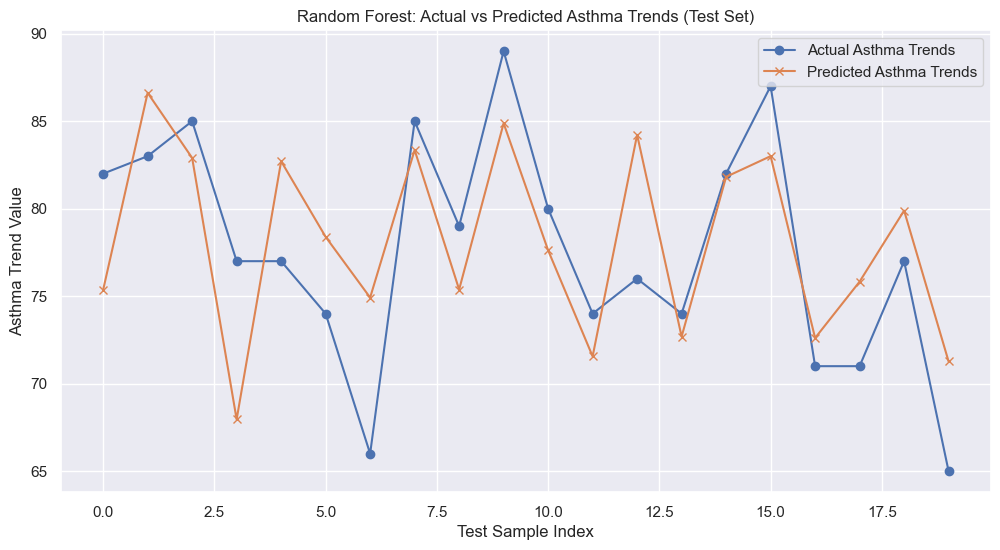

In [34]:
import matplotlib.pyplot as plt

# Predict on test set using previously trained Random Forest model
y_pred_rf = rf_model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Asthma Trends', marker='o')
plt.plot(y_pred_rf, label='Predicted Asthma Trends', marker='x')
plt.title('Random Forest: Actual vs Predicted Asthma Trends (Test Set)')
plt.xlabel('Test Sample Index')
plt.ylabel('Asthma Trend Value')
plt.legend()
plt.grid(True)
plt.show()


## 🧾 Final Interpretation and Conclusion

The final multiple linear regression model, which included **PM2.5 levels**, **temperature**, and **seasonal context**, achieved an **R² score of 0.444**. This indicates that about **44.4% of the variation** in asthma-related Google search trends can be explained by these environmental factors.

### 🔍 Key Takeaways:
- Simple linear models using only PM2.5 yielded **very low explanatory power** (R² ~ 0.001–0.022).
- Incorporating **1-week lagged pollution** improved results slightly but remained weak.
- Adding **seasonal features** and **temperature** significantly improved model performance, showing that asthma trends are influenced not just by pollution, but also by **climate and time of year**.
- The project demonstrates the value of **feature engineering** and **contextual variables** in public health analytics.

### 📚 Broader Impact:
This kind of analysis can inform **policy-makers**, **health departments**, and **urban planners** by identifying when and how environmental conditions drive public concern about respiratory health. While the model is not predictive on an individual level, it shows promise for broader public health surveillance.

---

